In [21]:
import torch
import torchvision 
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchinfo import summary
import torchvision.datasets as datasets


from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [3]:
def contar_parametros(model):
    total_parametros = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_parametros

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:


mnist_dataset=datasets.MNIST(root='./data',train=True,download=False,transform=transforms.ToTensor())
mnist_testset=datasets.MNIST(root='./data',train=False,download=False,transform=transforms.ToTensor())

In [6]:
print(len(mnist_dataset))
print(len(mnist_testset))
print(len(mnist_dataset[0]))


60000
10000
2


In [67]:
def show_loaded_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    
    for i in range(num_images):
        # Convertir la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    
    plt.show()

In [7]:
#Mezclando datos
Dataset=mnist_dataset+mnist_testset
print(len(Dataset))

70000


In [8]:
train_size = int(0.8 * len(Dataset))  # 80% para entrenamiento
test_size = len(Dataset) - train_size  # 20% para prueba
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Dividir el conjunto de entrenamiento en entrenamiento (90% de 80%) y validación (10% de 80%)
train_size = int(0.9 * len(train_dataset))  # 90% del conjunto de entrenamiento
val_size = len(train_dataset) - train_size  # 10% para validación
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [9]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

50400
14000
5600


In [10]:
class Neural_network(nn.Module):
    def __init__(self, layers, neurons):
        super(Neural_network, self).__init__()
        
        self.flatten = nn.Flatten()  # Para aplanar las imágenes de 28x28
        
        # Definir las capas básicas
        basic_layers = []
        
        # Primera capa lineal
        
        if neurons<=1:
            neurons=1
        
        basic_layers.append(('fc1', nn.Linear(28*28, neurons)))
        #basic_layers.append(('relu1', nn.ReLU()))  # Aplicar ReLU después de la primera capa
        
        # Añadir capas ocultas adicionales si layers > 1
        for i in range(2, layers+2):
            basic_layers.append((f'fc{i+1}', nn.Linear(neurons, neurons)))  # Capas adicionales
            basic_layers.append((f'relu{i+1}', nn.LeakyReLU()))  # ReLU para cada capa oculta
        
        # Capa de salida con Softmax (normaliza las salidas)
        basic_layers.append(('output', nn.Linear(neurons, 10)))  # Asumiendo una clasificación de 10 clases
        basic_layers.append(('softmax', nn.Softmax(dim=1)))  # Softmax en la última capa para clasificación

        # Crear la secuencia de capas con OrderedDict
        self.linear_stack = nn.Sequential(OrderedDict(basic_layers))
    
    def forward(self,x):
        x=self.flatten(x)
        logits=self.linear_stack(x)
        return logits

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer,epochs):
    val_loss = 0.0
    accuracy=0.0
    accuracy_t=[]
    val_loss_t=[]
    
    for epoch in range(epochs):
        model.train()  # Modo de entrenamiento
        running_loss = 0.0
        
        # Entrenamiento en conjunto de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Limpiar los gradientes acumulados
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Evaluar el modelo en el conjunto de validación
        model.eval()  # Modo de evaluación
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No calcular gradientes durante validación
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcular las predicciones correctas
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calcular las pérdidas promedio y precisión
        running_loss /= len(train_loader)
        val_loss /= len(val_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
        accuracy_t.append(accuracy)
        val_loss_t.append(val_loss)
    return [running_loss,val_loss,accuracy],accuracy_t,val_loss_t

In [28]:
def test_loop(model, test_loader, criterion):
    model.eval()  # Poner el modelo en modo evaluación
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Desactivar cálculo de gradientes
        for inputs, labels in test_loader:
            # Mover los datos a la GPU (o CPU, dependiendo del dispositivo)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass (sin backward ni actualización de pesos)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Obtener las predicciones
            _, predicted = torch.max(outputs, 1)  # `torch.max` devuelve el índice con el valor más alto (predicción)
            total += labels.size(0)  # Contar cuántas etiquetas tenemos
            correct += (predicted == labels).sum().item()  # Comparar predicciones con etiquetas verdaderas
    
    # Calcular la pérdida y la precisión
    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct / total
    
    print(f'Average Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}')
    return avg_test_loss, accuracy

# Llamar al test loop
# model = ...  # Asegúrate de que tu modelo esté definido
# test_loader = ...  # DataLoader para el conjunto de prueba
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model.to(device)  # Mover el modelo a GP

In [34]:
models=[Neural_network(1,i) for i in range(0,10,2)]

In [35]:
params=[]
for model in models:
    print(contar_parametros(model))
    params.append(contar_parametros(model))

807
1606
3210
4822
6442


In [36]:


summary(models[1], input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Neural_network                           [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 2]                    1,570
│    └─Linear: 2-2                       [1, 2]                    6
│    └─LeakyReLU: 2-3                    [1, 2]                    --
│    └─Linear: 2-4                       [1, 10]                   30
│    └─Softmax: 2-5                      [1, 10]                   --
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [37]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=1000)


In [38]:

model_stats=[]
acc_models=[]
loss_models=[]
for model in models: 
    model=model.to(device)
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    aux_stats,acc_hist,loss_hist=train_model(model,train_loader,val_loader,criterion,optimizer,epochs=35)
    acc_models.append(deepcopy(acc_hist))
    loss_models.append(deepcopy(loss_hist))
    model_stats.append(deepcopy(aux_stats))
    print(aux_stats)

Epoch 1/35, Loss: 2.2977, Val Loss: 2.2879, Accuracy: 0.1395
Epoch 2/35, Loss: 2.2797, Val Loss: 2.2705, Accuracy: 0.1461
Epoch 3/35, Loss: 2.2657, Val Loss: 2.2604, Accuracy: 0.1411
Epoch 4/35, Loss: 2.2577, Val Loss: 2.2542, Accuracy: 0.1964
Epoch 5/35, Loss: 2.2523, Val Loss: 2.2499, Accuracy: 0.1970
Epoch 6/35, Loss: 2.2485, Val Loss: 2.2466, Accuracy: 0.1982
Epoch 7/35, Loss: 2.2457, Val Loss: 2.2441, Accuracy: 0.1986
Epoch 8/35, Loss: 2.2430, Val Loss: 2.2420, Accuracy: 0.1986
Epoch 9/35, Loss: 2.2413, Val Loss: 2.2401, Accuracy: 0.1991
Epoch 10/35, Loss: 2.2395, Val Loss: 2.2385, Accuracy: 0.1993
Epoch 11/35, Loss: 2.2379, Val Loss: 2.2368, Accuracy: 0.1991
Epoch 12/35, Loss: 2.2360, Val Loss: 2.2351, Accuracy: 0.1991
Epoch 13/35, Loss: 2.2343, Val Loss: 2.2332, Accuracy: 0.1991
Epoch 14/35, Loss: 2.2326, Val Loss: 2.2311, Accuracy: 0.2005
Epoch 15/35, Loss: 2.2300, Val Loss: 2.2291, Accuracy: 0.2079
Epoch 16/35, Loss: 2.2283, Val Loss: 2.2272, Accuracy: 0.2127
Epoch 17/35, Loss

In [39]:
for stat in model_stats:
    print(stat)

[2.2009056689692477, 2.200730284055074, 0.24589285714285714]
[2.023557062242545, 2.0172590812047324, 0.455]
[1.698159654935201, 1.6969535152117412, 0.7871428571428571]
[1.5765358256358726, 1.581256091594696, 0.8844642857142857]
[1.62419873826644, 1.6329019665718079, 0.8303571428571429]


In [40]:
acc=[i[2] for i in model_stats]
err=[i[-1] for i in loss_models]

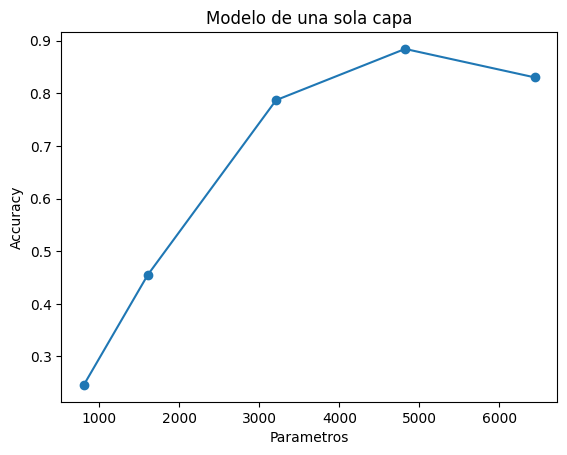

In [41]:
plt.plot(params,acc,marker='o')
plt.xlabel('Parametros')
plt.ylabel('Accuracy')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

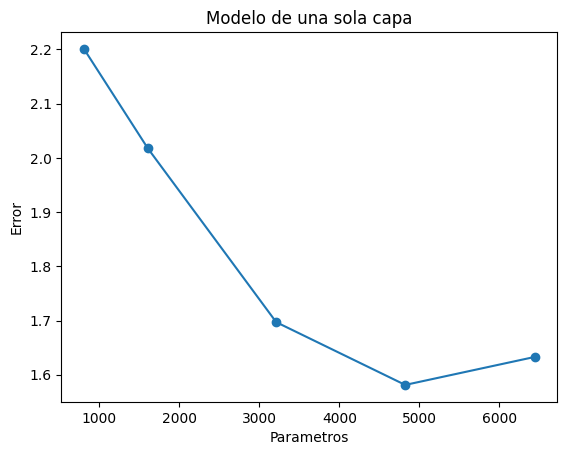

In [42]:
plt.plot(params,err,marker='o')
plt.xlabel('Parametros')
plt.ylabel('Error')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

In [43]:
neuronas=[i*2 for i in range(0,10,2)]

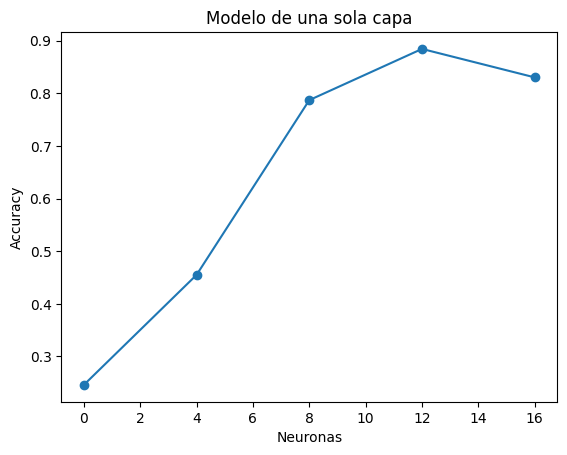

In [44]:
plt.plot(neuronas,acc,marker='o')
plt.xlabel('Neuronas')
plt.ylabel('Accuracy')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

In [46]:
loss_t=[]
acc_t=[]
for model in models:
    auxl,auxa=test_loop(model,test_loader,criterion = nn.CrossEntropyLoss())
    loss_t.append(auxl)
    acc_t.append(auxa)

Average Test Loss: 2.2013, Accuracy: 0.2398
Average Test Loss: 2.0262, Accuracy: 0.4434
Average Test Loss: 1.6967, Accuracy: 0.7833
Average Test Loss: 1.5821, Accuracy: 0.8854
Average Test Loss: 1.6273, Accuracy: 0.8371


## Redes de varias capas

In [13]:
models=[Neural_network(i,i) for i in range(0,10,2)]

In [14]:
params=[]
for model in models:
    print(contar_parametros(model))
    params.append(contar_parametros(model))

805
1612
3270
5032
6946


In [18]:

summary(models[1], input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Neural_network                           [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 2]                    1,570
│    └─Linear: 2-2                       [1, 2]                    6
│    └─LeakyReLU: 2-3                    [1, 2]                    --
│    └─Linear: 2-4                       [1, 2]                    6
│    └─LeakyReLU: 2-5                    [1, 2]                    --
│    └─Linear: 2-6                       [1, 10]                   30
│    └─Softmax: 2-7                      [1, 10]                   --
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

In [22]:
model_stats=[]
acc_models=[]
loss_models=[]
for model in models: 
    model=model.to(device)
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    aux_stats,acc_hist,loss_hist=train_model(model,train_loader,val_loader,criterion,optimizer,epochs=35)
    acc_models.append(deepcopy(acc_hist))
    loss_models.append(deepcopy(loss_hist))
    model_stats.append(deepcopy(aux_stats))
    print(aux_stats)

Epoch 1/35, Loss: 2.0848, Val Loss: 2.0793, Accuracy: 0.3829
Epoch 2/35, Loss: 2.0837, Val Loss: 2.0778, Accuracy: 0.3857
Epoch 3/35, Loss: 2.0818, Val Loss: 2.0764, Accuracy: 0.3875
Epoch 4/35, Loss: 2.0806, Val Loss: 2.0750, Accuracy: 0.3889
Epoch 5/35, Loss: 2.0791, Val Loss: 2.0736, Accuracy: 0.3914
Epoch 6/35, Loss: 2.0780, Val Loss: 2.0725, Accuracy: 0.3934
Epoch 7/35, Loss: 2.0770, Val Loss: 2.0712, Accuracy: 0.3962
Epoch 8/35, Loss: 2.0761, Val Loss: 2.0700, Accuracy: 0.3982
Epoch 9/35, Loss: 2.0744, Val Loss: 2.0690, Accuracy: 0.3979
Epoch 10/35, Loss: 2.0734, Val Loss: 2.0678, Accuracy: 0.3998
Epoch 11/35, Loss: 2.0727, Val Loss: 2.0667, Accuracy: 0.4018
Epoch 12/35, Loss: 2.0713, Val Loss: 2.0657, Accuracy: 0.4034
Epoch 13/35, Loss: 2.0706, Val Loss: 2.0649, Accuracy: 0.4020
Epoch 14/35, Loss: 2.0695, Val Loss: 2.0637, Accuracy: 0.4048
Epoch 15/35, Loss: 2.0683, Val Loss: 2.0628, Accuracy: 0.4061
Epoch 16/35, Loss: 2.0676, Val Loss: 2.0618, Accuracy: 0.4111
Epoch 17/35, Loss

In [23]:
for stat in model_stats:
    print(stat)
acc=[i[2] for i in model_stats]
err=[i[-1] for i in loss_models]

[2.0521291050256467, 2.046935558319092, 0.4332142857142857]
[1.9397804269603653, 1.9373450875282288, 0.5360714285714285]
[1.837071937673232, 1.841282347838084, 0.61875]
[1.7831967321096682, 1.7809402147928874, 0.6819642857142857]
[1.8521058162053425, 1.8561242024103801, 0.6076785714285714]


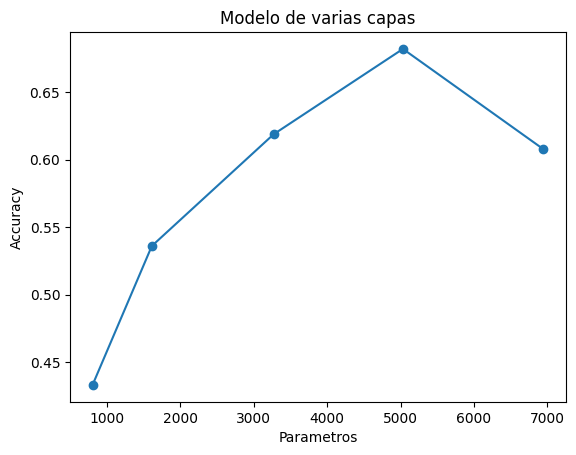

In [24]:
plt.plot(params,acc,marker='o')
plt.xlabel('Parametros')
plt.ylabel('Accuracy')

# Añadir un título
plt.title('Modelo de varias capas')

# Mostrar la gráfica
plt.show()

In [30]:
loss_t=[]
acc_t=[]
for model in models:
    auxl,auxa=test_loop(model,test_loader,criterion = nn.CrossEntropyLoss())
    loss_t.append(auxl)
    acc_t.append(auxa)

Average Test Loss: 2.0603, Accuracy: 0.4171
Average Test Loss: 1.9466, Accuracy: 0.5254
Average Test Loss: 1.8484, Accuracy: 0.6121
Average Test Loss: 1.7890, Accuracy: 0.6747
Average Test Loss: 1.8632, Accuracy: 0.5996
